In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [2]:
TIME_STEP = 1/1000
CLIP_IERR = 100

In [3]:
class Plant:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        ax += self.noise[0]
        ay += self.noise[1]
        az += self.noise[2]
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP**2
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP**2
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP**2
        self.__vx += ax*TIME_STEP
        self.__vy += ay*TIME_STEP
        self.__vz += az*TIME_STEP
        return self.__x, self.__y, self.__z

In [4]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd, clip_ierr=None):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.ierr = 0
        self.__prev_err = 0
        self.__clip_ierr = clip_ierr
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = self.ierr + err*TIME_STEP
        if self.__clip_ierr is not None:
            self.ierr = np.clip(self.ierr, -self.__clip_ierr, self.__clip_ierr)
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

In [5]:
class Target:
    
    def __init__(self, scale=1, momentum=0.5):
        self.__plant = Plant(noise_scale=0)
        self.__scale = scale
        self.__momentum = momentum
        self.__a = np.zeros((3,))
    
    def step(self):
        self.__a = self.__a*self.__momentum + \
            (1-self.__momentum)*np.random.randn(3)
        return self.__plant.step(*self.__a*self.__scale)

final noise 4.016368093015771 -2.43594274988348 -0.029945104592983857
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 0.7788043858407079 0.03402671838620819 0.001239530383095655


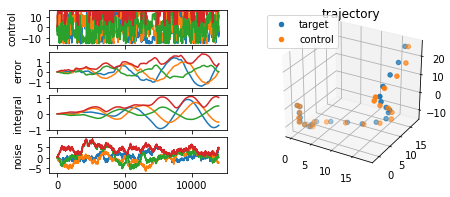

In [6]:
Kp,Ki,Kd = 10,100,35
control_max = 15
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
pid_x, pid_y, pid_z = [PIDController(Kp,Ki,Kd,clip_ierr=CLIP_IERR) for _ in range(3)]
x,y,z = plant.step(0,0,0)
T, Y, C, E, I, N = [[] for _ in range(6)]
for t in range(12000):
    tx,ty,tz = target.step()
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    clen = np.linalg.norm((cx,cy,cz))
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((tx-x,ty-y,tz-z,np.linalg.norm((tx-x,ty-y,tz-z))))
    I.append((pid_x.ierr,pid_y.ierr,pid_z.ierr,np.linalg.norm((pid_x.ierr,pid_y.ierr,pid_z.ierr))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

In [7]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [8]:
class PIDCell(keras.layers.Layer):
    
    def __init__(self, units, clip_ierr=None, **kwargs):
        self.units = units
        self.state_size = (units, units, units)
        self.__clip_ierr = clip_ierr
        super(PIDCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(PIDCell, self).build(input_shape)
    
    def call(self, inputs, states):
        dt, err, Kp, Ki, Kd = inputs[:,0:1], \
            inputs[:,1:self.units+1],inputs[:,self.units+1:self.units+2], \
            inputs[:,self.units+2:self.units+3],inputs[:,self.units+3:self.units+4]
        _, perr, ierr = states
        ierr = ierr+err*dt
        if self.__clip_ierr is not None:
            ierr = K.clip(ierr, -self.__clip_ierr, self.__clip_ierr)
        derr = (err-perr)/dt
        perr = err
        output = K.softplus(Kp)*err + K.softplus(Ki)*ierr + K.softplus(Kd)*derr
        return output, [output, perr, ierr]

In [9]:
X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X_input_tar = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar])
X = keras.layers.LSTM(64, stateful=True, return_sequences=True)(X)
X_Kp = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Ki = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Kd = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X = keras.layers.Concatenate()([X_input_dt,X_input_err,X_Kp,X_Ki,X_Kd])
X_pid,_,_,X_ierr = keras.layers.RNN(PIDCell(3, clip_ierr=CLIP_IERR), stateful=True, return_sequences=True, return_state=True)(X)
X_Kp = keras.layers.Lambda(lambda x: K.softplus(x))(X_Kp)
X_Ki = keras.layers.Lambda(lambda x: K.softplus(x))(X_Ki)
X_Kd = keras.layers.Lambda(lambda x: K.softplus(x))(X_Kd)
M_control = keras.Model([X_input_dt,X_input_err,X_input_tar], X_pid)
M_control.compile('adam', 'mse')
M_control_freeze = keras.Model(
    [X_input_dt,X_input_err,X_input_tar],
    [X_pid,X_ierr,X_Kp,X_Ki,X_Kd])
M_control_freeze.trainable = False
M_control_freeze.compile('adam', 'mse')
M_control.summary()

X_input_ctl = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar,X_input_ctl])
X = keras.layers.TimeDistributed(keras.layers.Dense(256, activation='sigmoid', kernel_initializer='glorot_normal'))(X)
X = keras.layers.LSTM(128, stateful=True, return_sequences=True)(X)
X = keras.layers.TimeDistributed(keras.layers.Dense(3, kernel_initializer='he_normal'))(X)
M_plant = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant.compile('adam', 'mse')
M_plant_freeze = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant_freeze.trainable = False
M_plant_freeze.compile('adam', 'mse')
M_plant.summary()

X = M_control([X_input_dt,X_input_err,X_input_tar])
X = M_plant_freeze([X_input_err,X_input_tar,X])
M_train = keras.Model([X_input_dt,X_input_err,X_input_tar], X)
M_train.compile('adam', 'mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (1, 1, 3)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (1, 1, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (1, 1, 6)            0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (1, 1, 64)           18176       concatenate_1[0][0]              
__________

final noise -0.6838532670497391 -0.30635938267462054 -1.7602350727619436
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -21.39456249608798 26.69713189981453 -32.853595934660156


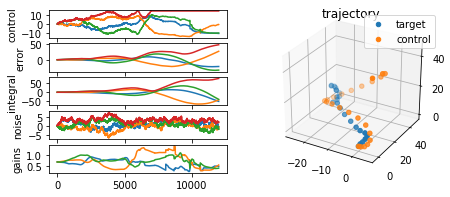

plant model loss [3.826786269200966e-06]
trainning model loss [710.9788208007812]
final noise -0.7063942395487389 -1.4175638652971356 0.598197021305475
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 128.4130316637906 118.12698109774372 -2.9754258855003926


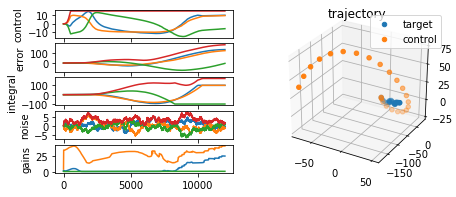

plant model loss [1.0286229553457815e-05]
trainning model loss [6525.09912109375]
final noise -0.4414720644782541 -2.8109661317425596 4.369693139196766
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 53.76464706180991 15.747781803951487 73.88863607867309


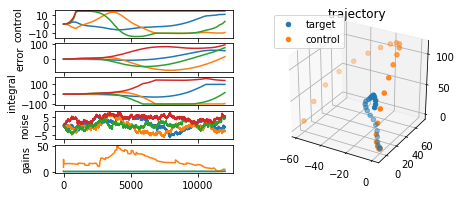

plant model loss [1.335654854774475]
trainning model loss [2199.12158203125]
final noise -0.17310635510426844 1.839519219840715 0.1499637864952858
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -0.38213721666642186 -3.965388467530749 -3.1513710667828105


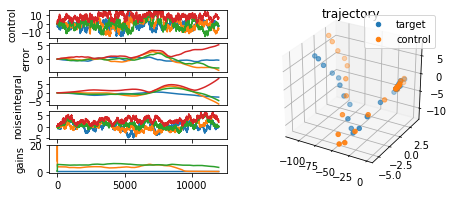

plant model loss [7.636379450559616e-06]
trainning model loss [8.589371681213379]
final noise -1.3210111428314821 -2.277562679313645 0.22091012659332437
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -0.005571095783814428 0.14487030996354378 -0.46744499210997503


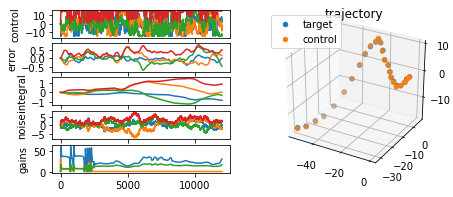

plant model loss [2.0313294157858763e-08]
trainning model loss [0.0798434168100357]
final noise -0.14980779620439583 -3.551038271836343 -1.5251012309415573
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 0.1415696935209425 0.06827014381993024 -0.09003322685823889


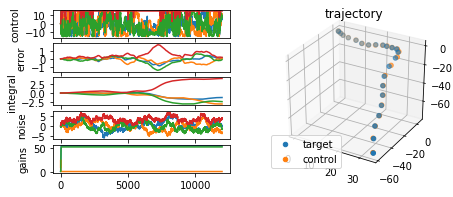

plant model loss [2.6892161386626867e-08]
trainning model loss [0.010992929339408875]
final noise 3.558087151773352 2.6309575028489944 0.3715482681650109
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -0.09212344698680397 0.11767601957744489 -0.2876027512606072


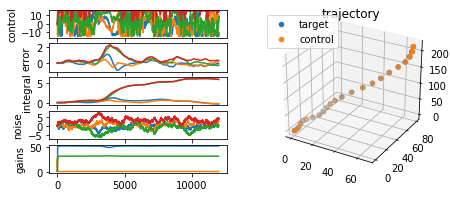

plant model loss [2.4643520646350225e-07]
trainning model loss [0.03480812534689903]
final noise 1.382536780740215 0.2922357071476624 -0.6330134850628685
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -0.3706562406507743 -0.15801029889372487 0.18389953463389475


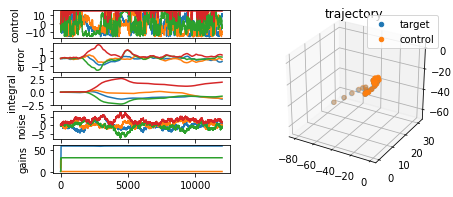

plant model loss [1.5143200471356977e-07]
trainning model loss [0.0651380717754364]
final noise -2.379388043075071 -0.11639946001271916 1.531493866391294
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 0.1089326869417988 0.027850806366402026 -0.024706574977411577


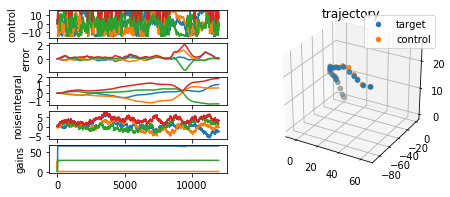

plant model loss [7.476799055439187e-07]
trainning model loss [0.00452610244974494]
final noise -2.7669907045248765 1.944910729455154 -1.943873537544085
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 0.0690531564217487 0.3876575485324327 -0.08185835236396244


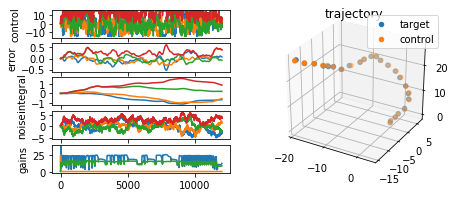

plant model loss [2.8788264216927928e-08]
trainning model loss [0.05373488739132881]
final noise -0.34956393983568473 -1.1572648708738904 -0.5863860200446022
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 1.6095481629151678 -0.21131810544011387 0.5616627778591692


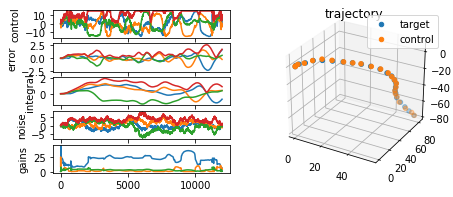

plant model loss [2.1832265417742747e-07]
trainning model loss [0.9872744679450989]
final noise 2.7346408491797596 -2.8218648714889984 4.490386409591822
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -72.97936301513515 -156.08514400089538 124.11585000466641


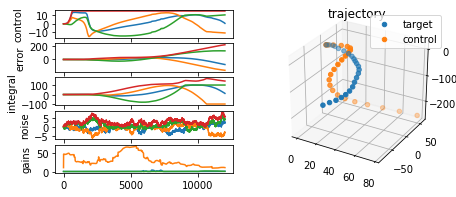

plant model loss [1.7000813484191895]
trainning model loss [14790.7841796875]
final noise 1.3279333477273734 4.007417000121311 -0.37794453723153215
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 127.84812514331945 -217.93334718250333 -51.5913986575315


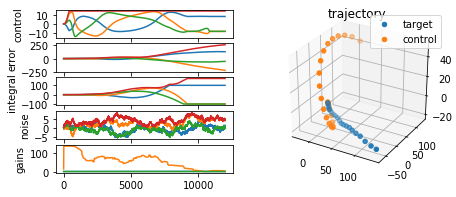

plant model loss [333.0624084472656]
trainning model loss [16169.5322265625]
final noise -0.8214226954613492 0.5464933273402257 -4.024366808471137
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 40.530405725680225 -53.93177917234988 42.60513543348842


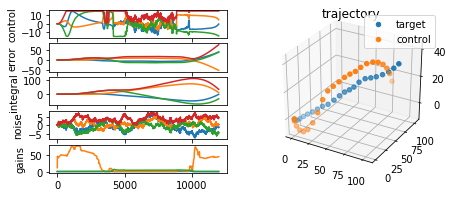

plant model loss [9.796253204345703]
trainning model loss [1100.138671875]
final noise -2.0551160476996464 -0.20733619335068038 0.7688160533946129
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 93.54588725615353 42.67778570055608 -41.429767822380185


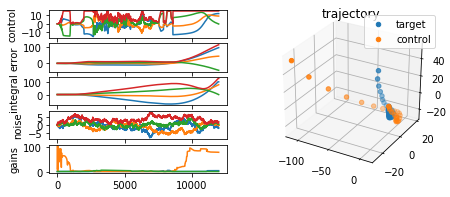

plant model loss [0.05152004957199097]
trainning model loss [3348.951171875]
final noise 3.072981140014398 2.7481928918029817 -0.41738571558189025
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -0.6203403805772325 -0.0013064218061273891 -1.8820759527149846


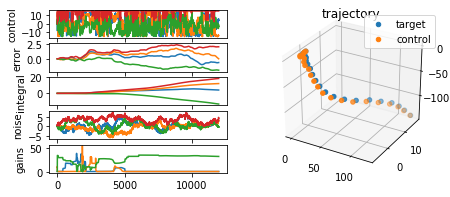

plant model loss [1.1168093578817206e-06]
trainning model loss [3.170941114425659]
final noise -1.3198582438849378 -1.524989914907823 3.114619850467763
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -1.607115266954077 1.543700828319345 -0.9482208683486348


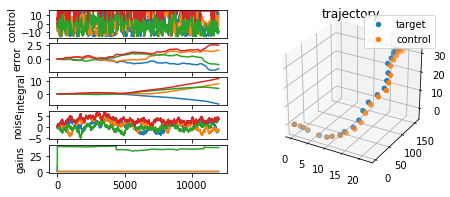

plant model loss [4.417982779614249e-08]
trainning model loss [1.95494544506073]
final noise -0.7377599718031732 -0.7742516091941534 -2.772749367854831
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 5.709833675250771 3.4603699797836462 14.075819805701343


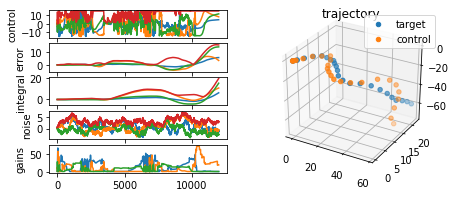

plant model loss [1.748950779756342e-07]
trainning model loss [64.30164337158203]
final noise -2.43822460441041 0.10295500171303548 2.3853868739058073
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -61.3345332914968 -6.516121301417063 7.943620607297461


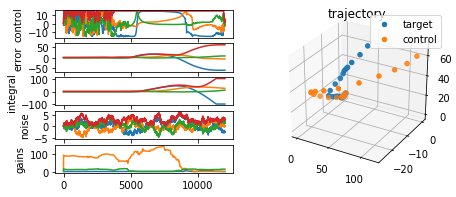

plant model loss [0.18806232511997223]
trainning model loss [1232.578369140625]
final noise -4.33865744395039 -0.9563145347330428 2.249531270390321
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -25.206328224519723 0.5853672707673852 -36.54333694663241


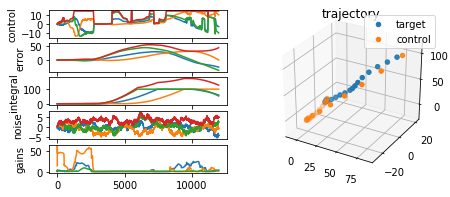

plant model loss [0.06254136562347412]
trainning model loss [663.3480224609375]
final noise -0.7762718882285723 4.268861227312042 -4.655443861498922
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 15.800275891450596 8.405423232903985 -62.61484927142684


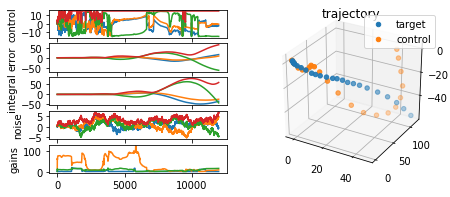

plant model loss [3.4945757389068604]
trainning model loss [1099.7855224609375]
final noise 3.2668519352992598 1.7895193504614337 0.6119871839435004
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 18.655063813181904 -0.37955761950771816 -20.91309432797376


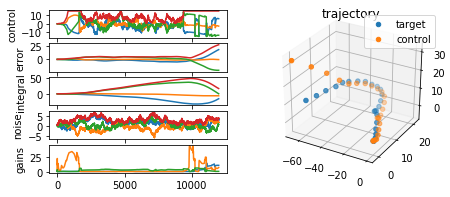

plant model loss [0.12395771592855453]
trainning model loss [177.50811767578125]
final noise -2.0598660103146855 -1.4733850190841342 0.02627676322219478
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -11.90754847247014 -28.912610261677237 25.705031136177155


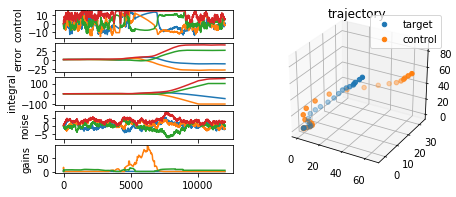

plant model loss [4.540646330042364e-07]
trainning model loss [546.1708984375]
final noise 0.9830130955560763 -0.5847119777726824 2.7987763226668947
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -0.3753612590870148 0.05616332130485091 0.5163513804618134


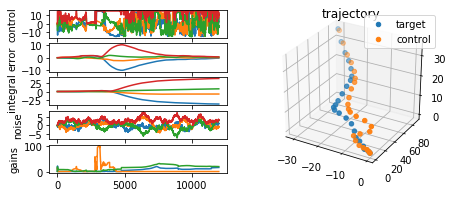

plant model loss [1.4668813491880428e-05]
trainning model loss [0.07856377959251404]
final noise -0.7155526033009123 2.386726661869555 -0.7551186851394479
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 0.39742310865314323 0.1543431125771093 -0.8343498431602754


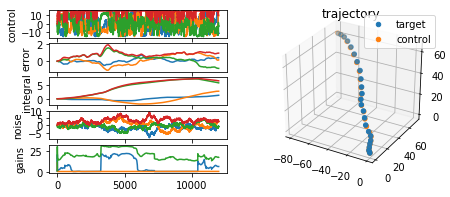

plant model loss [1.1120631597805186e-06]
trainning model loss [0.2871147096157074]
final noise -2.0633150450155755 0.7441213026648738 -0.4018868567780078
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -7.497938448867174 -11.459343429366761 -49.144216374273846


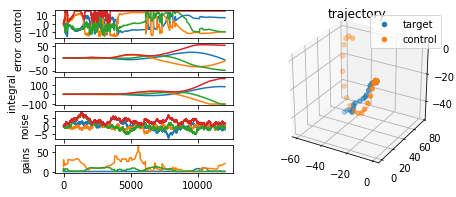

plant model loss [8.345637070306111e-06]
trainning model loss [830.0764770507812]
final noise 2.8806159196185437 1.6459555753971857 0.5527501282817607
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 0.6983530916081122 -2.880816787558274 2.790757374996474


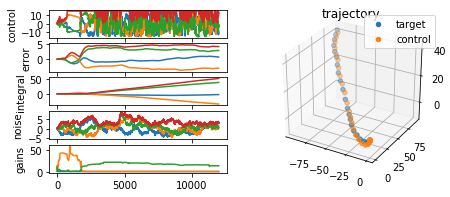

plant model loss [3.0816238449915545e-07]
trainning model loss [5.51904296875]
final noise -0.011976327188741476 -3.767738054581385 1.5385863496314207
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err 0.9616001148212163 -2.31891200462346 1.229158617942801


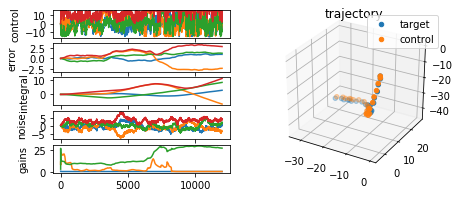

plant model loss [2.5686331355245784e-06]
trainning model loss [2.6035945415496826]
final noise 3.294655797553313 -1.1386642209288957 4.205468660939342
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -0.6734017677795094 -0.3914393915365366 -0.16004968214277682


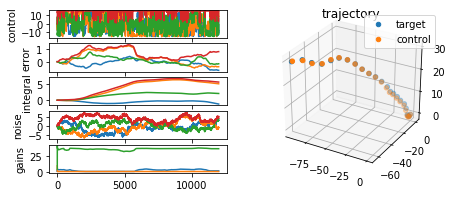

plant model loss [3.0867229270370444e-06]
trainning model loss [0.21214108169078827]
final noise 2.980559634935932 -2.5176379412630925 -1.534250842906639
final ierr -0.7231668026907649 -0.5174220452520983 0.4935633151737631
final err -9.233799842505206 -1.8739463046994445 -1.0729768011630085


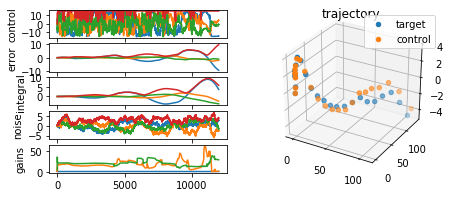

plant model loss [4.17682912257078e-07]
trainning model loss [30.01654815673828]
4min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 30 loops each)


In [10]:
%%timeit -n 30 -r 1

control_max = 15
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
x,y,z = plant.step(0,0,0)
ex,ey,ez = 0,0,0
T, Y, C, E, I, N, G = [[] for _ in range(7)]
M_control_freeze.reset_states()
for t in range(12000):
    tx,ty,tz = target.step()
    ctl,ierr,Kp,Ki,Kd = M_control_freeze.predict([
        np.array([[[TIME_STEP]]]),
        np.array([[[ex,ey,ez]]]),
        np.array([[[tx,ty,tz]]])-np.array([[[x,y,z]]])])
    cx,cy,cz = ctl[0,0]
    iex,iey,iez = ierr[0]
    clen = np.linalg.norm((cx,cy,cz))
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    ex,ey,ez = tx-x,ty-y,tz-z
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((ex,ey,ez,np.linalg.norm((ex,ey,ez))))
    I.append((iex,iey,iez,np.linalg.norm((iex,iey,iez))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
    G.append((Kp[0,0,0],Ki[0,0,0],Kd[0,0,0]))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', ex, ey, ez)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(521); plt.ylabel('control'); plt.plot(C)
plt.subplot(523); plt.ylabel('error'); plt.plot(E)
plt.subplot(525); plt.ylabel('integral'); plt.plot(I)
plt.subplot(527); plt.ylabel('noise'); plt.plot(N)
plt.subplot(529); plt.ylabel('gains'); plt.plot(G)
plt.show()

M_plant.reset_states()
for e,t,y,c,l in zip(E[:-1], T[1:], Y[:-1], C[1:], E[1:]):
    history = M_plant.fit(
        [np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]]),np.array([[c[:3]]])],
        np.array([[l[:3]]]), batch_size=1, shuffle=False, verbose=0)
print('plant model loss', history.history['loss'])

M_train.reset_states()
for e,t,y in zip(E[:-1], T[1:], Y[:-1]):
    history = M_train.fit(
        [np.array([[[TIME_STEP]]]),np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]])],
        np.array([[[0,0,0]]]), batch_size=1, shuffle=False, verbose=0)
print('trainning model loss', history.history['loss'])